In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h3
import xgboost as xgb
from tqdm import tqdm
import seaborn as sns
import re
import datetime
import os
import random
import h3

### 用維吉尼亞市的OHCA數據訓練XGB模型

In [22]:
h3_l7_df_VB = pd.read_csv('h3_l7_df_new.csv')
h3_l7_df_VB.drop(columns=['commercial;yes'], inplace=True)

train_index=[]
test_index=[]
for i in range(0,h3_l7_df_VB.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df_VB.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df_VB.iloc[train_index]
test_h3_l7_df = h3_l7_df_VB.iloc[test_index]

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df_VB.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df_VB.ohca.max()-h3_l7_df_VB.ohca.min()) + h3_l7_df_VB.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

# 分离特征和标签
X = spatial_data[:, :-1]  # 特征
Y = spatial_data[:, -1]   # 标签（OHCA）

X_train_reguli = train_spatial_data[:, :-1] 
y_train_reguli = train_spatial_data[:, -1] 
X_test_reguli = test_spatial_data[:, :-1] 
y_test_reguli = test_spatial_data[:, -1] 

# 定義XGBoost模型並指定參數
best_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=277,
    early_stopping_rounds=10,
    # 以下是您指定的參數值，請根據需要修改這些值
    max_depth=3,               # 樹的最大深度
    learning_rate=0.2,         # 學習率
    n_estimators=100,          # 樹的數量
    subsample=0.7,            # 每棵樹隨機採樣的比例 0.7
    colsample_bytree=0.7,      # 每棵樹使用的特徵比例 0.7
    gamma=0,                # 控制節點分裂的最小增益
    reg_alpha=0.1,            # L1正則化強度 0
    reg_lambda=1,           # L2正則化強度
    min_child_weight=3        # 每個葉子節點的最小樣本權重
)

# 訓練模型
best_xgb_model.fit(
    X_train_reguli, y_train_reguli,
    eval_set=[(X_test_reguli, y_test_reguli)],  # 提供測試集進行早停監控
    verbose=True
)

# 預測訓練集結果
y_head_train = best_xgb_model.predict(X_train_reguli) * ohca_reguli_inverse
y_train = y_train_reguli * ohca_reguli_inverse
# 預測測試集結果
y_head_test = best_xgb_model.predict(X_test_reguli) * ohca_reguli_inverse
y_test = y_test_reguli * ohca_reguli_inverse


#評估成效
train_mae = np.abs(y_head_train-y_train)
train_ans_mae = train_mae.sum()/train_mae.shape[0]
print('MAE of train set= ',train_ans_mae)
# 計算殘差變異
train_ss_residual = np.sum((y_train - y_head_train) ** 2)
# 計算總變異量
train_ss_total = np.sum((y_train - np.mean(y_train)) ** 2)
# 計算 R²
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

test_mae = np.abs(y_head_test-y_test)
test_ans_mae = test_mae.sum()/test_mae.shape[0]
print('MAE of test set= ',test_ans_mae)
# 計算殘差變異
test_ss_residual = np.sum((y_test - y_head_test) ** 2)
# 計算總變異量
test_ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
# 計算 R²
test_r_squared = 1 - (test_ss_residual / test_ss_total)
print("R² of test set= ", test_r_squared)

[0]	validation_0-rmse:0.24953
[1]	validation_0-rmse:0.22717
[2]	validation_0-rmse:0.21675
[3]	validation_0-rmse:0.19437
[4]	validation_0-rmse:0.17980
[5]	validation_0-rmse:0.17177
[6]	validation_0-rmse:0.16906
[7]	validation_0-rmse:0.16359
[8]	validation_0-rmse:0.15430
[9]	validation_0-rmse:0.14877
[10]	validation_0-rmse:0.14466
[11]	validation_0-rmse:0.14188
[12]	validation_0-rmse:0.14336
[13]	validation_0-rmse:0.14145
[14]	validation_0-rmse:0.13830
[15]	validation_0-rmse:0.13515
[16]	validation_0-rmse:0.13363
[17]	validation_0-rmse:0.13014
[18]	validation_0-rmse:0.12816
[19]	validation_0-rmse:0.12567
[20]	validation_0-rmse:0.12576
[21]	validation_0-rmse:0.12480
[22]	validation_0-rmse:0.12508
[23]	validation_0-rmse:0.12501
[24]	validation_0-rmse:0.12522
[25]	validation_0-rmse:0.12447
[26]	validation_0-rmse:0.12380
[27]	validation_0-rmse:0.12462
[28]	validation_0-rmse:0.12306
[29]	validation_0-rmse:0.12252
[30]	validation_0-rmse:0.12137
[31]	validation_0-rmse:0.12029
[32]	validation_0-

### 宜興市數據導入

In [19]:
h3_l7_df = pd.read_csv('h3_l7_df_yixing.csv')
h3_l7_df

,id,apartments,arts_centre,atm,bank,bar,barn,bus_station,cafe,car_wash,...,church,terrace,pavilion,stadium,cabin,boathouse,riding_hall,construction,ship,ruins
0,87309e000ffffff,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,87309e001ffffff,0,0,0,0,0,0,9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,87309e002ffffff,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,87309e003ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,87309e004ffffff,0,0,1,3,0,0,7,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,87309ebb2ffffff,9,0,1,1,1,0,10,4,0,...,0,0,0,0,0,0,0,0,0,0
428,87309ebb3ffffff,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
429,87309ebb4ffffff,0,0,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
430,87309ebb5ffffff,0,0,1,4,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# 隨便抓第一筆資料來檢查
sample_id = h3_l7_df['id'].iloc[0]
lat, lon = h3.h3_to_geo(sample_id)
print(f"H3中心座標: lat={lat}, lon={lon}")
# 如果 lat 是 36.x, lon 是 -76.x，那就是美國的座標

H3中心座標: lat=31.271219356703583, lon=119.68567060623714


成功對應到 432 個網格。


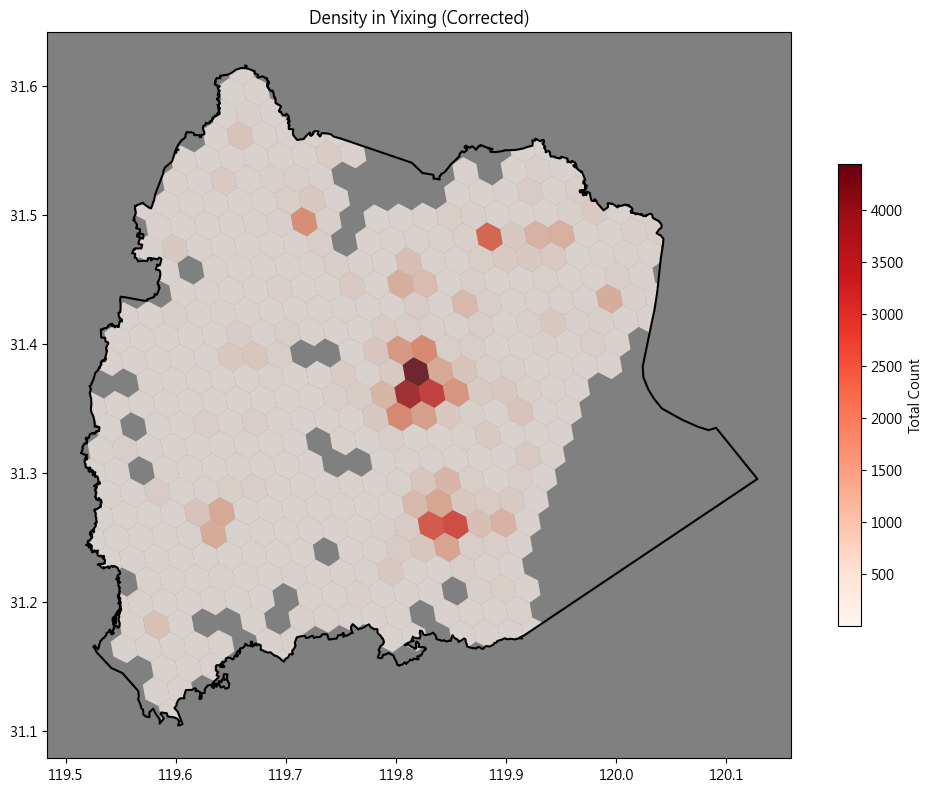

In [21]:
import matplotlib.pyplot as plt
import osmnx as ox
import h3
import geopandas as gpd
from shapely.geometry import Polygon

# 1. 獲取行政區 (宜興)
districts = ox.geocode_to_gdf(['Yixing, Wuxi, Jiangsu, China'])

# 2. 處理 H3 Data (假設 h3_l7_df 已經存在)
#    確保你的 h3_l7_df 裡面的 H3 ID 真的是屬於宜興的
#    這裡我們先計算 total_value
cols_to_sum = [c for c in h3_l7_df.columns if c != 'id']
h3_l7_df['total_value'] = h3_l7_df[cols_to_sum].sum(axis=1)

# 3. 將 H3 DataFrame 轉換為 GeoDataFrame (這一步是關鍵優化)
def h3_to_polygon(h3_id):
    # geo_json=True 返回 (lon, lat)，符合 GeoPandas/Matplotlib 的 (x, y) 順序
    boundary = h3.h3_to_geo_boundary(h3_id, geo_json=True)
    return Polygon(boundary)

# 建立幾何欄位
h3_l7_df['geometry'] = h3_l7_df['id'].apply(h3_to_polygon)
# 轉為 GeoDataFrame
gdf_h3 = gpd.GeoDataFrame(h3_l7_df, geometry='geometry', crs="EPSG:4326")

# 4. 重要的 Debug：過濾掉不在地圖範圍內的網格
# 這樣可以確保只畫出位於宜興內部的網格
gdf_h3_clipped = gpd.clip(gdf_h3, districts)

# 如果 clipped 後是空的，代表你的 H3 數據根本不在這個區域
if gdf_h3_clipped.empty:
    print("警告：沒有任何 H3 網格位於選定的行政區內！請檢查數據來源經緯度。")
else:
    print(f"成功對應到 {len(gdf_h3_clipped)} 個網格。")

# 5. 繪圖
fig, ax = plt.subplots(figsize=(12, 12))

# 畫底圖 (行政區)
districts.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, zorder=2)

# 畫網格 (一次性繪製，比 for 迴圈快非常多)
if not gdf_h3_clipped.empty:
    gdf_h3_clipped.plot(
        column='total_value',
        ax=ax,
        cmap='Reds',
        alpha=0.7,
        legend=True,
        legend_kwds={'label': "Total Count", 'shrink': 0.5},
        zorder=1
    )

ax.set_facecolor('grey')
ax.set_title('Density in Yixing (Corrected)') # 記得改標題
plt.show()